In [102]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn.metrics as metrics
from xgboost import XGBRegressor
from datetime import datetime
from sklearn.model_selection import train_test_split

In [6]:
# Warningを無効化
import warnings
warnings.simplefilter('ignore')

---
# main()

In [64]:
# 現在時刻の取得
dt_now = datetime.now()

In [14]:
# ファイル名
filename = dt_now.strftime('%Y%m%d-%H%M%S')
filename

'20230116-103828'

In [18]:
# 現在のディレクトリを取得
cdir = os.getcwd()
cdir

'/Users/yamashitataichi/Desktop/development/kabu_ai/notebooks'

In [23]:
# ルートディレクトリを取得
ROOT_PATH = cdir.replace('notebooks', '')
ROOT_PATH

'/Users/yamashitataichi/Desktop/development/kabu_ai/'

In [24]:
# result内のファイル一覧を取得
os.listdir(ROOT_PATH + 'data/result/')

[]

In [77]:
# データ読み込み
df = pd.read_csv(ROOT_PATH + 'data/data.csv')
df.head()

,timestamp,open,high,low,close,volume,datetime
0,1642496400000,305.99,305.99,303.30,304.4000,0.0,2022-01-18 09:00:00
1,1642500000000,304.40,305.19,303.60,304.9500,0.0,2022-01-18 10:00:00
2,1642503600000,305.05,305.17,303.50,303.9900,0.0,2022-01-18 11:00:00
3,1642507200000,303.84,304.99,303.50,304.6000,0.0,2022-01-18 12:00:00
4,1642510800000,304.70,310.20,300.41,304.7901,0.0,2022-01-18 13:00:00


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4164 entries, 0 to 4163
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4164 non-null   int64  
 1   open       4163 non-null   float64
 2   high       4163 non-null   float64
 3   low        4163 non-null   float64
 4   close      4163 non-null   float64
 5   volume     4163 non-null   float64
 6   datetime   4164 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 227.8+ KB


In [79]:
# 欠損値を線形補完
df = df.interpolate()

In [80]:
df.isna().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
datetime     0
dtype: int64

In [94]:
# テストデータセットを抽出
df_index = df.index
df_length = int(len(df_index) * 0.8)

df_test = df.loc[df_index[df_length:]]
df = df.drop(index=df_index[df_length:])

In [95]:
# 説明変数と目的変数を分割
X = df['open']
y = df['close']

In [96]:
# 学習データセット、検証データセットに分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [97]:
# モデルのインスタンス化
model = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.05,     # この値が少ないほど学習期間が長くなる。PCのスペックがより必要。
    eval_metric='logloss', 
    early_stopping_rounds=50, 
)

In [98]:
# 学習
eval_set = [(X_valid, y_valid)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[13:43:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:-9963.61426
[1]	validation_0-logloss:-9963.61426
[2]	validation_0-logloss:-9963.61426
[3]	validation_0-logloss:-9963.61426
[4]	validation_0-logloss:-9963.61426
[5]	validation_0-logloss:-9963.61426
[6]	validation_0-logloss:-9963.61426
[7]	validation_0-logloss:-9963.61426
[8]	validation_0-logloss:-9963.61426
[9]	validation_0-logloss:-9963.61426
[10]	validation_0-logloss:-9963.61426
[11]	validation_0-logloss:-9963.61426
[12]	validation_0-logloss:-9963.61426
[13]	validation_0-logloss:-9963.61426
[14]	validation_0-logloss:-9963.61426
[15

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='logloss', gamma=0,
             gpu_id=-1, importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [99]:
# 予測
X_test = df_test['open']
y_test = df_test['close']

y_pred = model.predict(X_test)

In [150]:
# RMSE
rmse = metrics.mean_squared_error(y_test, y_pred)
rmse

6.851283374512999

In [157]:
# 決定係数
r2 = metrics.r2_score(y_test, y_pred)
r2

0.9289928867808033

<BarContainer object of 7 artists>

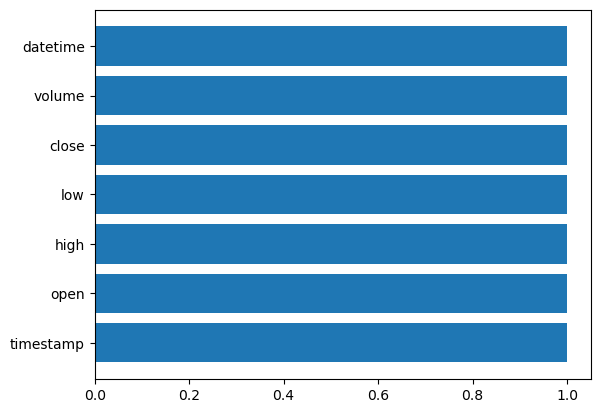

In [134]:
# importance
model.feature_importances_
plt.barh(df.columns, model.feature_importances_)

Text(0.05, 0.85, 'R2: 0.9289928867808033')

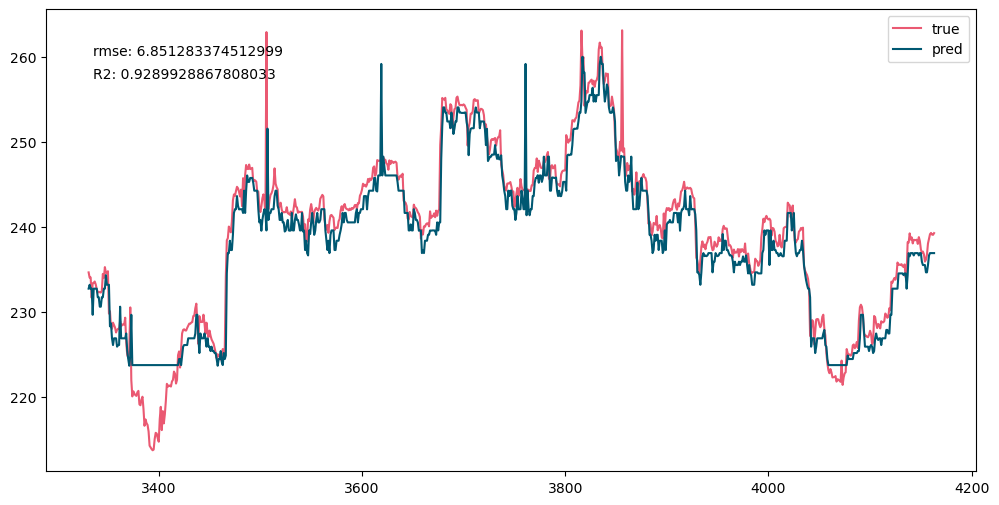

In [158]:
# 可視化
df_test['close_pred'] = y_pred

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.plot(df_test['close'], color='#ea5972', label='true')
ax.plot(df_test['close_pred'], color='#005872', label='pred')
ax.legend()
ax.text(0.05, 0.9, f'rmse: {rmse}', transform=ax.transAxes, fontsize=10)
ax.text(0.05, 0.85, f'R2: {r2}', transform=ax.transAxes, fontsize=10)